### Requirement : 

You need 'stlabutils' to load and plot the data efficiently.


In [1]:
import stlabutils
import numpy as np
import pickle
import multiprocessing as mp
import matplotlib.pyplot as plt
import matplotlib as mpl

from numpy import tan, pi, sqrt
from numpy.fft import fft, ifft
from scipy.optimize import minimize, curve_fit
from scipy.constants import e,h,hbar,k,G,epsilon_0
from lmfit import Model, Parameters

from qutip import *
qutip.settings.has_mkl=False
from scipy import signal

mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titlesize'] = 22
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['figure.titlesize'] = 22
mpl.rcParams['lines.linewidth'] = 2

# Give colours in hex
qubit     = '#664277'  # qubit
cavity1   = '#fa476f'  # cavity 1
cavity2   = '#c86464'  # cavity 2
coupling1 = '#68b799'  # coupling between qubit and cavity 1
coupling2 = '#7eb6a1'  # coupling between qubit and cavity 1
drive     = '#68b799'  # single-tone drive strength
driveq    = 'green'    # qubit-friendly drive tone strength
drivec    = 'cyan'     # cavity-friendly drive tone strenth
sbred     = '#c86464'  # P(e0)-P(g1), red sideband transitions
sbblue    = '#6196b3'  # P(e1)-P(g0), blue sideband transitions
hline     = 'gray'     # horizontal domain lines
# colormap  = 'gist_heat'   # colormap for color plots

# Plotting

In [2]:
# BSB detuning conversion factor 
cf = (6.58 + 2.224)/1e3/2/(5.41085-5.4101)

# Specify the path to your bsb data file
folder1 = '/home/jovyan/steelelab/measurement_data/newBF/Wouter/Wouter_spectra_around_resonant_condition/'
file1 = 'W_ls_2020_01_14_12.15.12_Resonator_split_Singletone-sideband-LT142W4_5D_C_60dB_Omegad_1/W_ls_2020_01_14_12.15.12_Omegad_1.dat'
filepath1 = folder1 + file1

# Load the bsb data
data1 = stlabutils.readdata.readdat(filepath1)

x1 = np.asarray(data1[0]['Frequency (Hz)'])*1e-6
x1 = x1 - 4.0755e3
y1 = np.linspace(5.4096e9, 5.4116e9, 81)*1e-6
y1 = y1 - 5.41065e3
y1 = y1 * cf
z1 = np.zeros([y1.shape[0], x1.shape[0]])
for i, line in enumerate(data1):
    line['S21_lin ()'] = (line['S21re ()']**2 + line['S21im ()']**2)
    z1[i] = np.asarray(line['S21_lin ()'])
    
# Specify the path to your rsb data file
folder2 = '/home/jovyan/steelelab/measurement_data/newBF/Bann_paper/BS-transmon/'
file2 = 'B1_2019_09_03_02.16.44_Singletone-sideband-LT142W4_5D_C_40dB-prove_3dB_drive_!!!/B1_2019_09_03_02.16.44_Singletone-sideband-LT142W4_5D_C_40dB-prove_3dB_drive_!!!.dat'
filepath2 = folder2 + file2

# Load the rsb data
data2 = stlabutils.readdata.readdat(filepath2)

x2 = np.asarray(data2[0]['Frequency (Hz)'])*1e-6
x2 = x2 - 4.0807e3
y2 = np.linspace(1.305e9, 1.307e9, 21)*1e-6
y2 = y2 - 1.306e3
z2 = np.zeros([y2.shape[0], x2.shape[0]])
for i, line in enumerate(data2):
    line['S21_lin ()'] = (line['S21re ()']**2 + line['S21im ()']**2)
    z2[i] = np.asarray(line['S21_lin ()'])

['Frequency (Hz)', 'S21re ()', 'S21im ()', 'S21dB (dB)', 'S21Ph (rad)', 'Power (dBm)']
['Frequency (Hz)', 'S21re ()', 'S21im ()', 'S21dB (dB)', 'S21Ph (rad)', 'Power (dBm)']


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


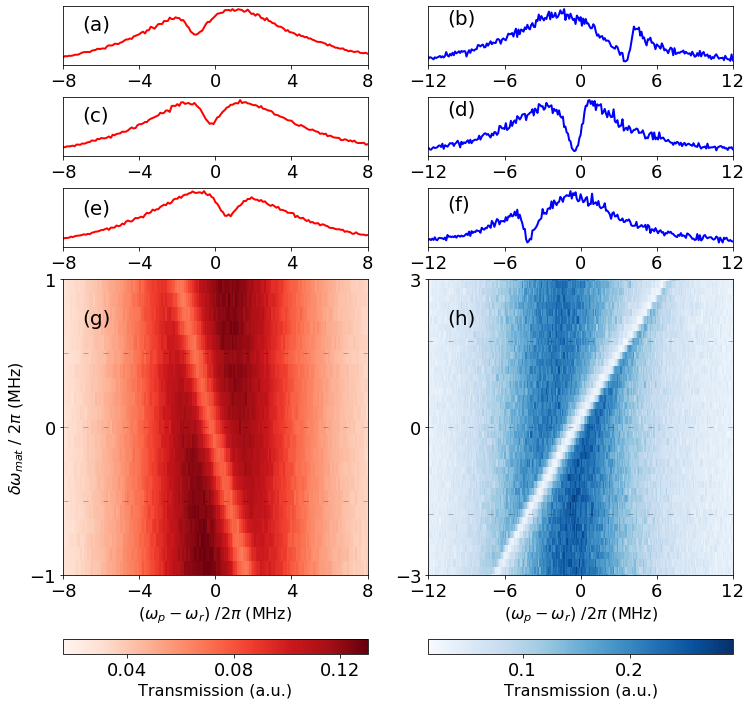

In [3]:
red_cutting_off2 = 5
blue_cutting_off2 = 30

red_cutting = 10
blue_cutting = 42

red_cutting_off1 = 15
blue_cutting_off1 = 54

def plot_line(y):
    plt.axhline(y, ls=(0,(10,30)), lw=0.5,c='k', alpha=0.5)

fig = plt.subplots(figsize=(12,12))
grid = plt.GridSpec(16,2, wspace=0.2, hspace=2.5)

plt.subplot(grid[:2, 0])
plt.plot(x2,z2[red_cutting_off1]*1e7,'r-')
plt.xticks([-8, -4, 0, 4, 8])
plt.yticks([])
plt.xlim([-8,8])
plt.text(-7,0.8e2,'(a)',fontsize=20)

plt.subplot(grid[:2, 1])
plt.plot(x1,z1[blue_cutting_off1]*1e7,'b-')
plt.xticks([-12,-6, 0, 6,12])
plt.yticks([])
plt.xlim([-12,12])
plt.text(-7*1.5,1.8e-1,'(b)',fontsize=20)

plt.subplot(grid[2:4, 0])
plt.plot(x2,z2[red_cutting]*1e7,'r-')
plt.xticks([-8, -4, 0, 4, 8])
plt.yticks([])
plt.xlim([-8,8])
plt.text(-7,0.8e2,'(c)',fontsize=20)

plt.subplot(grid[2:4, 1])
plt.plot(x1,z1[blue_cutting]*1e7,'b-')
plt.xticks([-12,-6, 0, 6,12])
plt.yticks([])
plt.xlim([-12,12])
plt.text(-7*1.5,1.8e-1,'(d)',fontsize=20)

plt.subplot(grid[4:6, 0])
plt.plot(x2,z2[red_cutting_off2]*1e7,'r-')
plt.xticks([-8, -4, 0, 4, 8])
plt.yticks([])
plt.xlim([-8,8])
plt.text(-7,0.8e2,'(e)',fontsize=20)

plt.subplot(grid[4:6, 1])
plt.plot(x1,z1[blue_cutting_off2]*1e7,'b-')
plt.xticks([-12,-6, 0, 6,12])
plt.yticks([])
plt.xlim([-12,12])
plt.text(-7*1.5,1.8e-1,'(f)',fontsize=20)

plt.subplot(grid[6:, 0])
#plt.pcolormesh(x2, y2, z2*1e4, cmap='Reds')
extent = [x2[0], x2[-1], y2[0],y2[-1]]
plt.imshow(z2*1e4, cmap='Reds', aspect='auto', extent=extent, origin='lower')
plt.xticks([-8, -4, 0, 4, 8])
plt.yticks([-1, 0, 1])
plt.xlim([-8,8])
plt.xlabel("$(\\omega_p-\\omega_r)$ $/2\\pi$ (MHz)",fontsize=16)
plt.ylabel("$\\delta\\omega_{mat}~/~2\\pi$ (MHz)",fontsize=16)
plot_line(y2[red_cutting])
plot_line(y2[red_cutting_off1])
plot_line(y2[red_cutting_off2])
plt.text(-7,0.7,'(g)',fontsize=20)
# plt.colorbar(ticks=[0,0.1],extendfrac='Auto')
cbar = plt.colorbar(ticks=[0,0.04,0.08,0.12], orientation="horizontal", pad=0.15)
cbar.set_label('Transmission (a.u.)',fontsize=16)

plt.subplot(grid[6:, 1])
#plt.pcolormesh(x1, y1, z1*1e7, cmap='Blues')
extent = [x1[0], x1[-1], y1[0],y1[-1]]
plt.imshow(z1*1e7, cmap='Blues', aspect='auto', extent=extent, origin='lower')
plt.xticks([-12,-6, 0, 6,12])
plt.yticks([-3, 0, 3])
plt.xlim([-12,12])
plt.ylim([-3,3])
# plt.ylabel("$\\delta\\omega_{mat}~/~2\\pi$ (MHz)",fontsize=16)
plt.xlabel("$(\\omega_p-\\omega_r)$ $/2\\pi$ (MHz)",fontsize=16)
plot_line(y1[blue_cutting])
plot_line(y1[blue_cutting_off1])
plot_line(y1[blue_cutting_off2])
plt.text(-7*1.5,0.7*3,'(h)',fontsize=20)
cbar = plt.colorbar(label='Transmission (a.u.)',ticks=[0,0.1,0.2,0.3], orientation="horizontal", pad=0.15)
cbar.set_label('Transmission (a.u.)',fontsize=16)
# plt.ylabel("$\\omega_d$ $/2\\pi$ [GHz]")
plt.subplots_adjust(wspace=0.05)
plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(top=0.93)
plt.tight_layout()
plt.show()
